In [1]:
import sys

#!{sys.executable} -m pip install gensim==3.8.3 --user
#!{sys.executable} -m pip install fse
#pip install --upgrade gensim

In [3]:
from fse.models import SIF
from fse import IndexedList

In [2]:
import os, re, gzip, json, pickle, shutil, random, joblib
from collections import Counter

import numpy as np

from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

#from fse.models import SIF
#from fse import IndexedList

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%config IPCompleter.greedy=True
%matplotlib inline

In [5]:
#load training data sample
feats = []
y = []
labels = []

if os.path.exists('../data/1000000_features_x.pkl.gz'):
    print('loading stored features')
    with gzip.open('../data/1000000_features_x.pkl.gz', 'rb') as fz:
        feats = pickle.load(fz)
        
    labels = [feat['type'] for feat in feats]
    
    with gzip.open('../data/1000000_features_y.pkl', 'rb') as fz:
        y = pickle.load(fz)
else:
    feats = []
    with gzip.open('troll_features.pkl.gz', 'rb') as f:
        feats = pickle.load(f)
    with gzip.open('user_features.pkl.gz', 'rb') as f:
        user_feats = pickle.load(f)
    while user_feats:
        feats.append(user_feats.pop())

    random.shuffle(feats)

    y = [0 if feat['type']=='NormalUser' else 1 for feat in feats]
    labels = [feat['type'] for feat in feats]

    with gzip.open('data/features_x.pkl.gz', 'wb') as oz:
        pickle.dump(feats, oz)

    with gzip.open('data/features_y.pkl.gz', 'wb') as oz:
        pickle.dump(y, oz)

feats = feats[:1000000]
y = y[:1000000]

len(feats), len(y)

loading stored features


(1000000, 1000000)

In [7]:
random.choice(feats)
#user=XX NNP XX, XX ADD XX, XX XX XX    
#link = TAG, XX NNP ADD, XX NNP XX
#hash = $ NNS, $ NN, LS NNS, LS NN, NN NN, NNS NNP, $ NNP, $ JJ
#emoji = XX ADD XX

{'type': 'RightTroll',
 'text': 'RT usmcwalter: elgatoweebee DebAlwaystrump WayneDupreeShow Crooked Hillary should be in prison, instead she is walking down the street In …',
 'tokens': 'RT usmcwalter : elgatoweebee DebAlwaystrump WayneDupreeShow Crooked Hillary should be in prison , instead she is walking down the street In …',
 'lemmas': 'rt usmcwalter : elgatoweebee debalwaystrump waynedupreeshow crooked hillary should be in prison , instead she be walk down the street in …',
 'pos': 'NNP NN : NNP NNP NNP NNP NNP MD VB IN NN , RB PRP VBZ VBG IN DT NN IN NFP',
 'phrases': 'RT_usmcwalter elgatoweebee_DebAlwaystrump_WayneDupreeShow Crooked_Hillary the_street',
 'entities': ['Crooked_Hillary:GPE', 'DebAlwaystrump:PERSON'],
 'ent_types': ['PERSON', 'GPE'],
 'hashtags': [],
 'oov_words': 'rt usmcwalter elgatoweebee debalwaystrump waynedupreeshow …',
 'emoji_ratio': 0.0,
 'link_ratio': 0.0,
 'user_ratio': 0.0,
 'oov_ratio': 0.3}

In [6]:
lab_cts = Counter([feat['type'] for feat in feats])
lab2idx = {l:i for i,l in enumerate(sorted(lab_cts.keys()))}
idx2lab = {i:l for l,i in lab2idx.items()}
lab_cts, lab2idx

(Counter({'NormalUser': 500000,
          'NewsFeed': 190952,
          'HashtagGamer': 37957,
          'LeftTroll': 86389,
          'RightTroll': 178738,
          'Unknown': 2516,
          'Fearmonger': 3109,
          'Commercial': 339}),
 {'Commercial': 0,
  'Fearmonger': 1,
  'HashtagGamer': 2,
  'LeftTroll': 3,
  'NewsFeed': 4,
  'NormalUser': 5,
  'RightTroll': 6,
  'Unknown': 7})

In [125]:
#
# input feature decisions
#

In [10]:
# lemmas
lemmas = [f['lemmas'].strip() for f in feats]

In [24]:
#tokens
tokens = [f['tokens'].strip() for f in feats]

In [ ]:
#
# vectorization choices
#

In [ ]:
# word level

In [15]:
def train_w2v(texts, model_path, vec_dim=128, window=5):
    model = Word2Vec(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained word2vec model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model


def train_ft(texts, model_path, vec_dim=128, window=5):
    model = FastText(sentences=texts, size=vec_dim, window=window, min_count=10, workers=4)
    model.train(texts, total_examples=len(texts), epochs=5)

    print('...Storing trained fasttext model')
    model.save(model_path)
    
    for word in ['one', 'cat', 'fun', 'stupid', 'lol']:
        print('close to %s' % word)
        for w,s in model.wv.most_similar(word):
            print('   %s, %.6f' % (w,s))
            
    return model

In [9]:
lemma_texts = [[t for t in l.split(' ') if t and not t[0]=='#'] for l in lemmas]

NameError: name 'lemmas' is not defined

In [ ]:
token_texts = [[t for t in l.split(' ') if t] for l in tokens]

In [16]:
# w2v, lemmas, dim 128
w2v_lemma_128_model = train_w2v(lemma_texts, model_path='w2v_lemmas_128.model', vec_dim=128, window=5)

...Storing trained word2vec model
close to one
   two, 0.528386
   person, 0.525269
   few, 0.495751
   those, 0.478265
   couple, 0.469130
   none, 0.468374
   all, 0.467734
   circumstance, 0.466530
   people, 0.449952
   half, 0.446448
close to cat
   dog, 0.768505
   kitten, 0.675289
   pup, 0.626476
   kid, 0.611600
   monkey, 0.569790
   tooth, 0.566439
   puppy, 0.559516
   animal, 0.558335
   neighbor, 0.554280
   pet, 0.553323
close to fun
   nice, 0.573867
   cool, 0.565338
   rad, 0.549932
   great, 0.549778
   productive, 0.528884
   funn, 0.520655
   awesome, 0.519056
   wonderful, 0.504871
   busy, 0.499129
   exciting, 0.492510
close to stupid
   dumb, 0.755384
   lame, 0.625272
   silly, 0.608922
   rude, 0.600138
   ignorant, 0.579645
   annoying, 0.578674
   retard, 0.569122
   disrespectful, 0.565114
   retarded, 0.564741
   funny, 0.558755
close to lol
   lmao, 0.898959
   haha, 0.846718
   smh, 0.795913
   lmfao, 0.793658
   hahaha, 0.774476
   hahahaha, 0.768137
 

In [123]:
# w2v, lemmas, dim 256
w2v_lemma_256_model = train_w2v(lemma_texts, model_path='w2v_lemmas_256.model', vec_dim=256, window=5)

...Storing trained sound2vec model
close to one
   two, 0.448975
   few, 0.410538
   suitability, 0.407115
   couple, 0.397480
   the, 0.397439
   three, 0.393882
   tip--->the, 0.387105
   all, 0.386697
   a, 0.385734
   ., 0.379138
close to cat
   dog, 0.661289
   pet, 0.608568
   puppy, 0.598654
   kitten, 0.551233
   pup, 0.512244
   squirrel, 0.480887
   kitty, 0.477398
   baby, 0.476338
   kid, 0.458036
   rat, 0.457804
close to fun
   awesome, 0.535683
   great, 0.525589
   wonderful, 0.497025
   lovely, 0.494863
   fabulous, 0.490123
   fab, 0.489692
   productive, 0.488108
   cool, 0.480049
   exciting, 0.462467
   amazing, 0.449394
close to stupid
   dumb, 0.657611
   annoying, 0.578262
   silly, 0.564563
   ignorant, 0.550392
   ridiculous, 0.544230
   rude, 0.542862
   disrespectful, 0.542400
   retarded, 0.535405
   funny, 0.524030
   selfish, 0.517017
close to lol
   lmao, 0.829179
   haha, 0.773410
   hahaha, 0.698409
   smh, 0.673527
   hahahaha, 0.643388
   lmfao, 0.62

In [131]:
#w2v, tokens, dim 128
w2v_token_128_model = train_w2v(token_texts, model_path='w2v_tokens_128.model', vec_dim=128, window=5)

...Storing trained sound2vec model
close to one
   that, 0.544262
   all, 0.542002
   the, 0.527094
   two, 0.524907
   ever, 0.523339
   none, 0.517389
   idea, 0.506869
   ., 0.505605
   probably, 0.505523
   every, 0.505509
close to cat
   dog, 0.793956
   kid, 0.711720
   mom, 0.698905
   puppy, 0.698001
   pig, 0.670382
   neighbor, 0.660032
   girl, 0.659851
   pet, 0.648049
   dick, 0.643885
   kitty, 0.638729
close to fun
   great, 0.696657
   awesome, 0.662878
   nice, 0.654193
   good, 0.634327
   yummy, 0.625666
   fantastic, 0.617634
   wonderful, 0.613989
   lovely, 0.595838
   cool, 0.588377
   amazing, 0.584752
close to stupid
   dumb, 0.842282
   silly, 0.713347
   weird, 0.693167
   nasty, 0.691529
   annoying, 0.683807
   ridiculous, 0.662998
   lame, 0.660129
   bad, 0.658177
   pathetic, 0.651594
   crazy, 0.645935
close to lol
   lmao, 0.868555
   haha, 0.865577
   hahaha, 0.808599
   tho, 0.758458
   Lol, 0.753484
   hehe, 0.726271
   smh, 0.716959
   ugh, 0.71621

In [132]:
#w2v, tokens, 256
w2v_token_256_model = train_w2v(token_texts, model_path='w2v_tokenss_256.model', vec_dim=256, window=5)

...Storing trained sound2vec model
close to one
   One, 0.495533
   that, 0.447047
   ones, 0.444940
   it, 0.441734
   none, 0.438723
   the, 0.438007
   actually, 0.431425
   all, 0.428275
   probably, 0.427818
   a, 0.425618
close to cat
   dog, 0.709076
   kid, 0.627297
   puppy, 0.618728
   pet, 0.614548
   mom, 0.608734
   stomach, 0.589888
   girl, 0.588567
   dad, 0.582434
   kitten, 0.582301
   neighbor, 0.581532
close to fun
   great, 0.595284
   awesome, 0.589718
   nice, 0.569110
   yummy, 0.563595
   wonderful, 0.543489
   good, 0.530406
   lovely, 0.526065
   fabulous, 0.525797
   amazing, 0.521620
   fantastic, 0.519801
close to stupid
   dumb, 0.767547
   silly, 0.637046
   annoying, 0.617520
   ignorant, 0.605048
   nasty, 0.604947
   weird, 0.602731
   retarded, 0.596429
   pathetic, 0.586576
   selfish, 0.586516
   lame, 0.584568
close to lol
   lmao, 0.812920
   haha, 0.812479
   hahaha, 0.723108
   Lol, 0.687083
   smh, 0.660511
   ugh, 0.650724
   omg, 0.643699
  

In [17]:
#fasttext, lemmas, 128
ft_lemmas_128_model = train_ft(lemma_texts, model_path='ft_lemmas_128.model', vec_dim=128, window=5)

...Storing trained fasttext model
close to one
   onee, 0.820704
   onesie, 0.774576
   -one, 0.748360
   everone, 0.747349
   somone, 0.704005
   oneness, 0.694810
   rhone, 0.673491
   lonesome, 0.660673
   cone, 0.657946
   scone, 0.654922
close to cat
   dog, 0.821988
   kitten, 0.750573
   catnip, 0.737246
   bobcat, 0.721807
   goat, 0.711068
   copycat, 0.701107
   doggone, 0.690640
   lapdog, 0.690587
   piglet, 0.689397
   pussycat, 0.689034
close to fun
   funk, 0.644428
   coool, 0.626376
   cool, 0.615977
   awesome, 0.607270
   funky, 0.606563
   gruesome, 0.603585
   great, 0.602117
   nice, 0.594990
   funn, 0.590773
   lonesome, 0.568202
close to stupid
   stupidly, 0.880847
   dumb, 0.750870
   stupidity, 0.736315
   dumbe, 0.734706
   dumbass, 0.677114
   lame, 0.664017
   silly, 0.660901
   wack, 0.657014
   retarded, 0.654972
   annoying, 0.653011
close to lol
   lolol, 0.930699
   -lol, 0.914208
   lmao, 0.909472
   lol'd, 0.906990
   lol-, 0.901445
   lol., 0.8982

In [136]:
#fasttext, lemmas, 256
ft_lemmas_256_model = train_ft(lemma_texts, model_path='ft_lemmas_256.model', vec_dim=256, window=5)

...Storing trained fasttext model
close to one
   fone, 0.701703
   -one, 0.693428
   onesie, 0.655465
   symone, 0.639824
   none, 0.617256
   lone, 0.604999
   noone, 0.601255
   cone, 0.600139
   scone, 0.598966
   tone, 0.580369
close to cat
   catnip, 0.720033
   dog, 0.709774
   doggy, 0.607227
   catfish, 0.606916
   bearcat, 0.605866
   doggie, 0.604154
   pet, 0.595842
   cato, 0.593532
   wildcat, 0.592099
   dogs, 0.587409
close to fun
   funky, 0.587895
   awesome, 0.574896
   funn, 0.568032
   funk, 0.555044
   great, 0.547545
   lovely, 0.536375
   greatful, 0.533253
   wonderful, 0.531241
   greasy, 0.529379
   gruesome, 0.521142
close to stupid
   stupidly, 0.853046
   stupidity, 0.736236
   unfunny, 0.646589
   dumb, 0.620469
   hated, 0.584757
   funny, 0.574486
   stoopid, 0.573655
   annoying, 0.564437
   weirdly, 0.556444
   dumbe, 0.550423
close to lol
   lolol, 0.940002
   .lol, 0.899065
   lololol, 0.892308
   lol-, 0.877095
   lolololol, 0.847052
   lolzz, 0.81

In [ ]:
# document level

In [8]:
def plot_tsne(vecs, lab_idxs, idx2lab):
    lab2idx = {l:i for i,l in idx2lab.items()}
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=2000)
    tsne_results = tsne.fit_transform(vecs)

    vis_x = tsne_results[:,0]
    vis_y = tsne_results[:,1]
    
    num_labs = len(idx2lab)
    colors = ['red','aqua','orange','green','blue','black','purple','yellow','magenta','cyan'][:num_labs]

    fig, ax = plt.subplots(figsize=(14,14))
    ax.scatter(vis_x, vis_y, c=[colors[i] for i in lab_idxs], 
               s=10, cmap=matplotlib.colors.ListedColormap(colors))
    ax.legend()
    plt.show()

In [22]:
#sum weighted word vecs by tfidf

tfidf_vectorizer = TfidfVectorizer(max_features=100000, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(lemmas)
tfidf_vocab = tfidf_vectorizer.get_feature_names()
tfidf.shape

(1000000, 100000)

In [24]:
#get tfidf score for certain words in a doc
lemmas[0], tfidf[0, tfidf_vocab.index('good')], tfidf[0, tfidf_vocab.index('video')], tfidf[0, tfidf_vocab.index('junie')]

('rt :  good to see junie browning back to be junie browning ( video ):',
 0.12757042787237405,
 0.14400746374901582,
 0.7282515582684614)

In [54]:
def get_sum_tfidf_weighted_word_vectors(texts, word_model, tfidf, tfidf_vocab, out_path):
    sum_w2v_vecs = []
    #labs = []
    file_idx = 0
    eps = 0.01
    
    for i in range(len(texts)):
        wts = []
        vecs = []
        
        for tk in texts[i].split(' '):
            if tk not in word_model.wv:
                continue

            vecs.append(word_model.wv[tk])

            if tk not in tfidf_vocab:
                wts.append(eps)
            else:
                wts.append(tfidf[i, tfidf_vocab.index(tk)])
        
        wts = np.array(wts)
        if not vecs:
            #just add random word vec
            idx = random.randint(0,len(word_model.wv)-1)
            sum_w2v_vecs.append(word_model.wv[idx])
        else:
            wt_ttl = np.sum(wts)
            wts /= wt_ttl
            vecs = np.vstack(vecs)
            sum_w2v_vecs.append(np.dot(wts, vecs))
            #sum_w2v_vecs.append(np.sum([vecs[i]*wts[i] for i in range(len(wts))], axis=0))
        #labs.append(labels[i])
        
        if i and i%25000==0:
            print('%d, storing %s_%d.npy' % (i, out_path, file_idx))
            np.save('%s_%d.npy' % (out_path, file_idx), np.vstack(sum_w2v_vecs))
            file_idx+=1
            sum_w2v_vecs = []
            
    if sum_w2v_vecs:
        print('storing last %s_%d.npy' % (out_path, file_idx))
        np.save('%s_%d.npy' % (out_path, file_idx), np.vstack(sum_w2v_vecs))

In [ ]:
#weighted w2v lemma
out_path = 'sum_tfidf_weighted_w2v_lemma_128'
get_sum_tfidf_weighted_word_vectors(lemmas, w2v_lemma_128_model, tfidf, tfidf_vocab, out_path)

In [16]:
def plot_weighted_vecs(vecs, labels, color_map):
    lab_cts = Counter(labels)
    
    labels_to_plot = ['NewsFeed', 'NormalUser', 'RightTroll', 'LeftTroll', 'HashtagGamer']
    lab_vec_cts = {l:0 for l in labels_to_plot}
    min_ct = min([lab_cts[l] for l in labels_to_plot])
    print('min count: %d' % min_ct)
    
    balanced_vecs = {k:[] for k in lab_vec_cts}
    for i in range(vecs.shape[0]):
        l = labels[i]
        
        if l not in lab_vec_cts:
            continue
            
        if lab_vec_cts[l]<min_ct:
            lab_vec_cts[l]+=1
            balanced_vecs[l].append(vecs[i,:])
            
    for l,v in balanced_vecs.items():
        print(l,len(v))
        
    bal_vecs=[]
    for l in labels_to_plot:
        for v in balanced_vecs[l]:
            bal_vecs.append(v)
    bal_vecs = np.vstack(bal_vecs)
    print(bal_vecs.shape)
    
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=2000)
    tsne_results = tsne.fit_transform(bal_vecs)

    vis_x = tsne_results[:,0]
    vis_y = tsne_results[:,1]

    fig, ax = plt.subplots(figsize=(14,14))

    ax.scatter(vis_x[:min_ct], vis_y[:min_ct], c = color_map[labels_to_plot[0]], label = labels_to_plot[0], s=10)
    ax.scatter(vis_x[min_ct:2*min_ct], vis_y[min_ct:2*min_ct], c = color_map[labels_to_plot[1]], label =  labels_to_plot[1], s=10)
    ax.scatter(vis_x[2*min_ct:3*min_ct], vis_y[2*min_ct:3*min_ct], c = color_map[labels_to_plot[2]], label =  labels_to_plot[2], s=10)
    ax.scatter(vis_x[3*min_ct:4*min_ct], vis_y[3*min_ct:4*min_ct], c = color_map[labels_to_plot[3]], label =  labels_to_plot[3], s=10)
    ax.scatter(vis_x[4*min_ct:], vis_y[4*min_ct:], c = color_map[labels_to_plot[4]], label =  labels_to_plot[4], s=10)

    ax.legend()
    plt.show()

In [11]:
w2v_vecs = np.load('sum_tfidf_weighted_w2v_lemma_128.npy_0.npy')
w2v_vecs.shape

(25001, 128)

min count: 941
NewsFeed 941
NormalUser 941
RightTroll 941
LeftTroll 941
HashtagGamer 941
(4705, 128)
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4705 samples in 0.000s...
[t-SNE] Computed neighbors for 4705 samples in 1.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4705
[t-SNE] Computed conditional probabilities for sample 2000 / 4705
[t-SNE] Computed conditional probabilities for sample 3000 / 4705
[t-SNE] Computed conditional probabilities for sample 4000 / 4705
[t-SNE] Computed conditional probabilities for sample 4705 / 4705
[t-SNE] Mean sigma: 1.339278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.646225
[t-SNE] KL divergence after 2000 iterations: 2.577613


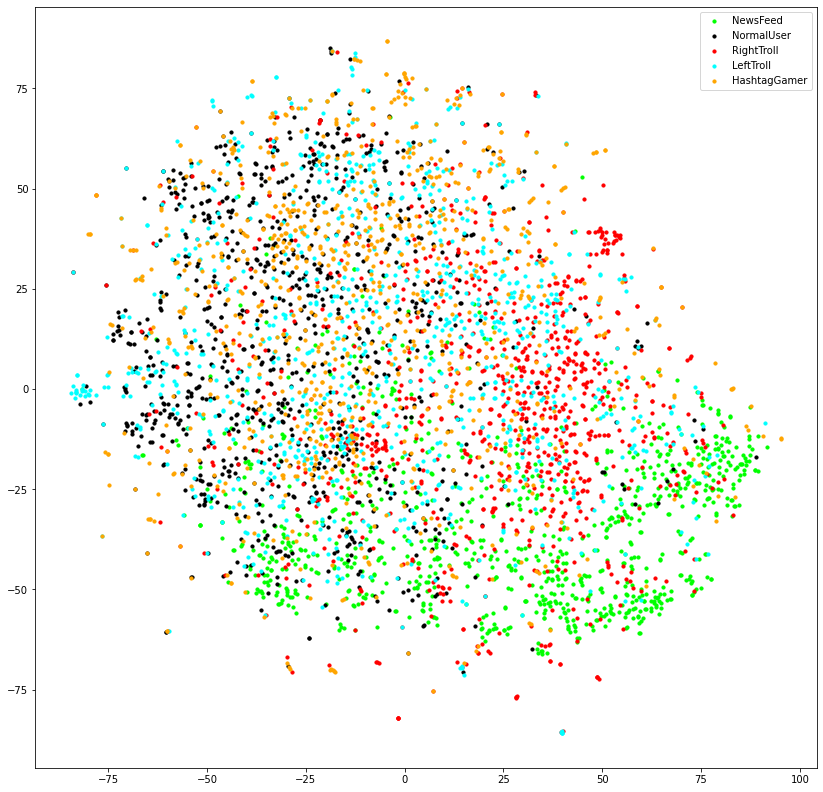

In [18]:
color_map = {'NewsFeed':'lime', 'NormalUser':'black', 'RightTroll':'red', 'LeftTroll':'aqua', 'HashtagGamer':'orange'}
plot_weighted_vecs(w2v_vecs, labels[:w2v_vecs.shape[0]], color_map)

min count: 941
NewsFeed 941
NormalUser 941
RightTroll 941
LeftTroll 941
HashtagGamer 941
(4705, 128)
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4705 samples in 0.008s...
[t-SNE] Computed neighbors for 4705 samples in 1.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4705
[t-SNE] Computed conditional probabilities for sample 2000 / 4705
[t-SNE] Computed conditional probabilities for sample 3000 / 4705
[t-SNE] Computed conditional probabilities for sample 4000 / 4705
[t-SNE] Computed conditional probabilities for sample 4705 / 4705
[t-SNE] Mean sigma: 1.339278
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.942871
[t-SNE] KL divergence after 2000 iterations: 2.591134


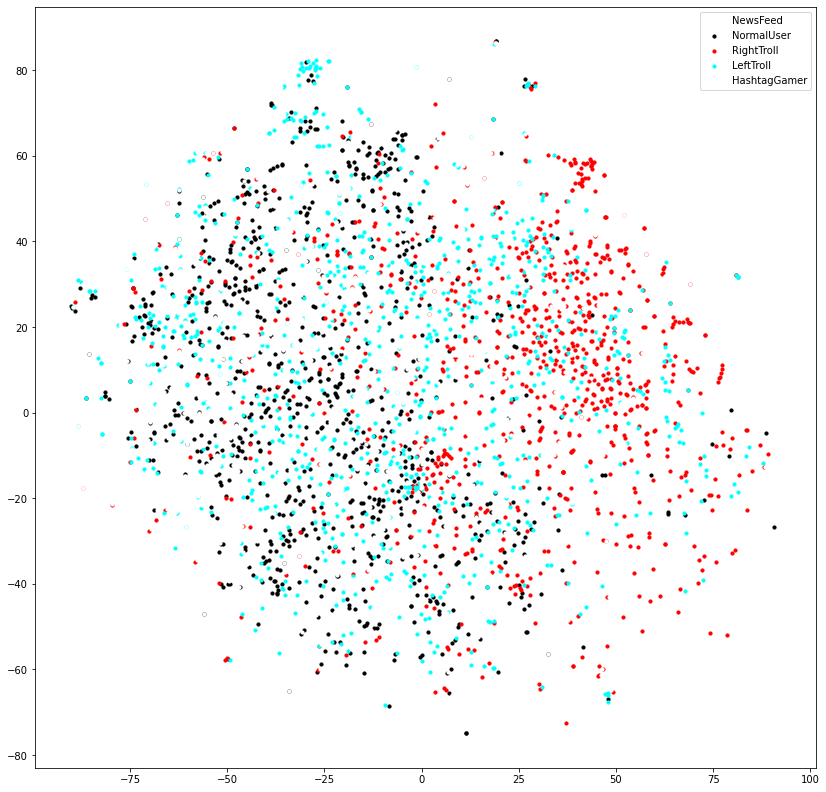

In [21]:
color_map = {'NewsFeed':'white', 'NormalUser':'black', 'RightTroll':'red', 'LeftTroll':'aqua', 'HashtagGamer':'white'}
plot_weighted_vecs(w2v_vecs, labels[:w2v_vecs.shape[0]], color_map)

In [ ]:
#weighted ft lemma
out_path = 'sum_tfidf_weighted_ft_lemma_128'
get_sum_tfidf_weighted_word_vectors(lemmas, ft_lemmas_128_model, tfidf, tfidf_vocab, out_path)

25000, storing sum_tfidf_weighted_ft_lemma_128.npy_0.npy
50000, storing sum_tfidf_weighted_ft_lemma_128.npy_1.npy
75000, storing sum_tfidf_weighted_ft_lemma_128.npy_2.npy
100000, storing sum_tfidf_weighted_ft_lemma_128.npy_3.npy
125000, storing sum_tfidf_weighted_ft_lemma_128.npy_4.npy
150000, storing sum_tfidf_weighted_ft_lemma_128.npy_5.npy
175000, storing sum_tfidf_weighted_ft_lemma_128.npy_6.npy
200000, storing sum_tfidf_weighted_ft_lemma_128.npy_7.npy
225000, storing sum_tfidf_weighted_ft_lemma_128.npy_8.npy
250000, storing sum_tfidf_weighted_ft_lemma_128.npy_9.npy
275000, storing sum_tfidf_weighted_ft_lemma_128.npy_10.npy
300000, storing sum_tfidf_weighted_ft_lemma_128.npy_11.npy
325000, storing sum_tfidf_weighted_ft_lemma_128.npy_12.npy
350000, storing sum_tfidf_weighted_ft_lemma_128.npy_13.npy
375000, storing sum_tfidf_weighted_ft_lemma_128.npy_14.npy
400000, storing sum_tfidf_weighted_ft_lemma_128.npy_15.npy
425000, storing sum_tfidf_weighted_ft_lemma_128.npy_16.npy
450000, st

In [11]:
ft_vecs = np.load('sum_tfidf_weighted_ft_lemma_128.npy_0.npy')
ft_vecs.shape

(25001, 128)

In [ ]:
color_map = {'NewsFeed':'lime', 'NormalUser':'black', 'RightTroll':'red', 'LeftTroll':'aqua', 'HashtagGamer':'orange'}
plot_weighted_vecs(ft_vecs, labels[:ft_vecs.shape[0]], color_map)

In [ ]:
color_map = {'NewsFeed':'white', 'NormalUser':'black', 'RightTroll':'red', 'LeftTroll':'aqua', 'HashtagGamer':'white'}
plot_weighted_vecs(ft_vecs, labels[:ft_vecs.shape[0]], color_map)

In [30]:
#FSE
fse_w2v_lemma_128_model = SIF(w2v_lemma_128_model)
_,_ = fse_w2v_lemma_128_model.train(IndexedList(lemma_texts))
fse_w2v_lemma_128_model.save('fse_w2v_lemma_128.model')

print('\n\nExamples')
for i, sent in enumerate(lemma_texts[:10]):
    print('\nSource sentence: %s' % ' '.join(sent))
    for idx, sc in fse_w2v_lemma_128_model.sv.most_similar(i, topn=5):
        print('\n    Similar - %.4f: %s' % (sc, ' '.join(lemma_texts[idx])))



Examples

Source sentence: sea lion blocks traffic on highway 37

    Similar - 0.8361: giant pothole on route 138 snarl lake arrowhead traffic

    Similar - 0.7842: barge capsize near destrehan , close mississippi river to ship traffic

    Similar - 0.7770: atlanta traffic horror : crew raze fall highway overpass

    Similar - 0.7689: mountain lion successfully crosses 101 freeway in thousand oaks

    Similar - 0.7669: lincoln tunnel bus collision injures at least 31 , snarl traffic

Source sentence: can not we just agree to move the damned " l " and call it " chipolte ? " you know it sound well . and it be too late for cultural authenticity .

    Similar - 0.6573: clinton : i very much appreciate that comment . now that we 've agree on an independent inquiry . we should move on .

    Similar - 0.6347: agree . why do he assume that race and gender be not contingency ? esp . in an economic sense .

    Similar - 0.6300: this " awesome read " say nothing . a guy name matlock , a

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.105652


No handles with labels found to put in legend.


[t-SNE] KL divergence after 2000 iterations: 3.099561


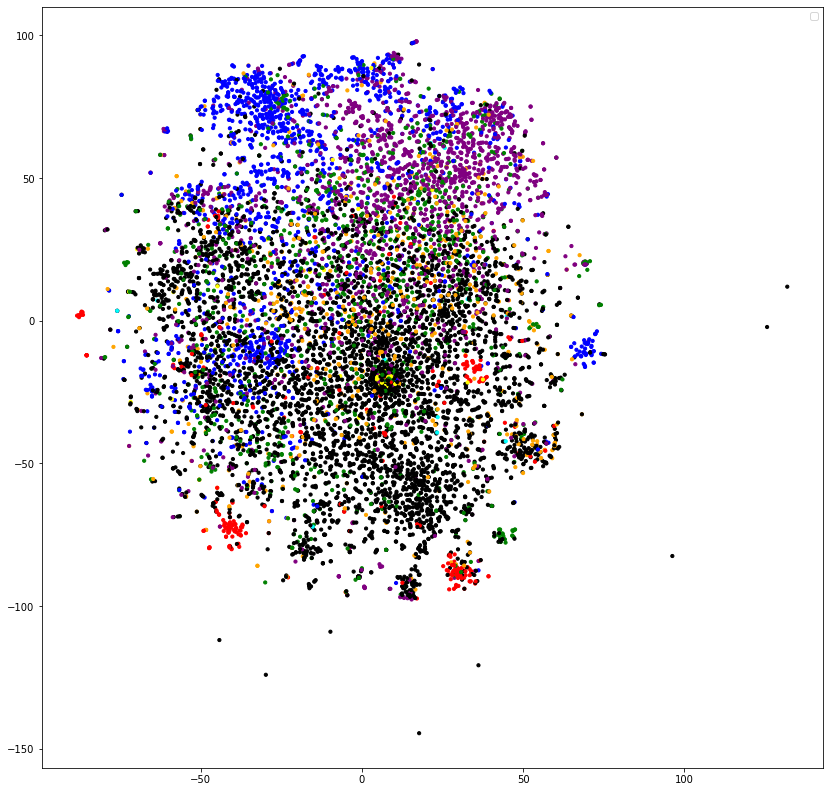

In [53]:
plot_tsne(fse_w2v_lemma_128_model.sv.vectors[:10000,:], [lab2idx[l] for l in labels[:10000]], idx2lab)

In [ ]:
#doc2vec

In [172]:
lemma_docs = [TaggedDocument(feat['lemmas'].split(' '), tags=[feat['type']]) for feat in feats[:1000000]]
lemma_docs[0]

TaggedDocument(words=['rt', ':', '', 'good', 'to', 'see', 'junie', 'browning', 'back', 'to', 'be', 'junie', 'browning', '(', 'video', '):', ''], tags=['NormalUser'])

In [173]:
d2v_lemmas_128_model = Doc2Vec(lemma_docs, vector_size=128, window=5, min_count=10, workers=4)
d2v_lemmas_128_model.save('d2v_lemmas_128.model')

In [174]:
lab_vecs = {}
for lab in lab2idx.keys():
    lab_vecs[lab] = d2v_lemmas_128_model.dv[lab]

In [176]:
len(feats)

1000000

In [177]:
def data_to_doc2vec_vectors(feats):
    labs = []
    predicted = []
    d2v_lemmas_128_vecs = []
    cor=0
    ttl=0
    file_idx=0
    
    for i,feat in enumerate(feats):
        v = d2v_lemmas_128_model.infer_vector(feat['lemmas'].split(' '))
        d2v_lemmas_128_vecs.append(v)
        labs.append(feat['type'])
        for l,sc in d2v_lemmas_128_model.dv.most_similar(v, topn=1): #positive=[v]
            predicted.append(l)
            #print(feat['type'], l, sc, '\n')
            if feat['type']==l:
                cor+=1
        ttl+=1

        if ttl % 10000 == 0:
            print(ttl, cor, cor/ttl)

        if i and i%100000==0:
            print('storing d2v_lemmas_128_%d.npy' % file_idx)
            np.save('d2v_lemmas_128_%d.npy' % file_idx, np.vstack(d2v_lemmas_128_vecs))
            file_idx+=1
            d2v_lemmas_128_vecs = []
            
    if d2v_lemmas_128_vecs:
        print('storing d2v_lemmas_128_%d.npy' % file_idx)
        np.save('d2v_lemmas_128_%d.npy' % file_idx, np.vstack(d2v_lemmas_128_vecs))
    
    print(classification_report(labs, predicted, target_names=sorted(list(lab2idx.keys()))))
    
    bin_labs = [l if l=='NormalUser' else 'TrollUser' for l in labs]
    bin_preds = [l if l=='NormalUser' else 'TrollUser' for l in predicted]
    print(classification_report(bin_labs, bin_preds, target_names=['NormalUser', 'TrollUser']))

    return labs, predicted

10000 3883 0.3883
20000 7781 0.38905
30000 11552 0.38506666666666667
40000 15372 0.3843
50000 19155 0.3831
60000 23027 0.3837833333333333
70000 26797 0.3828142857142857
80000 30655 0.3831875
90000 34506 0.3834
100000 38295 0.38295
storing d2v_lemmas_128_0.npy
110000 42130 0.383
120000 46005 0.383375
130000 49892 0.3837846153846154
140000 53633 0.3830928571428571
150000 57458 0.38305333333333336
160000 61304 0.38315
170000 65166 0.38332941176470586
180000 69087 0.38381666666666664
190000 72887 0.3836157894736842
200000 76752 0.38376
storing d2v_lemmas_128_1.npy
210000 80614 0.3838761904761905
220000 84431 0.38377727272727274
230000 88303 0.38392608695652175
240000 92137 0.38390416666666666
250000 95960 0.38384
260000 99832 0.3839692307692308
270000 103683 0.38401111111111114
280000 107574 0.38419285714285717
290000 111416 0.38419310344827584
300000 115279 0.38426333333333335
storing d2v_lemmas_128_2.npy
310000 119117 0.38424838709677417
320000 122997 0.384365625
330000 126850 0.38439393

In [207]:
lem =feats[0]['lemmas'].split(' ')
print(lem)
d2v_lemmas_128_model.infer_vector(lem)

['rt', ':', '', 'good', 'to', 'see', 'junie', 'browning', 'back', 'to', 'be', 'junie', 'browning', '(', 'video', '):', '']


array([-5.62090427e-02, -1.25061885e-01, -2.36839186e-02,  1.24107070e-01,
       -5.37913665e-02,  7.49679431e-02, -6.54570311e-02, -5.02423681e-02,
       -7.79599771e-02,  4.75835614e-03, -1.63297489e-01, -9.65543240e-02,
       -3.40601355e-02, -3.44109014e-02, -6.78320527e-02, -6.64863437e-02,
       -1.08258940e-01,  4.64118675e-05,  7.45863318e-02, -5.56372777e-02,
       -2.15077940e-02, -6.28877208e-02,  6.61435276e-02,  1.97646409e-01,
        5.66402078e-02, -6.84984550e-02, -9.32702273e-02, -2.83564199e-02,
       -8.95558205e-03, -1.91887617e-02,  3.28908823e-02, -9.61399451e-02,
        5.19491872e-03,  1.50892019e-01,  3.63575108e-02, -1.12713151e-01,
       -7.03306347e-02, -1.98326875e-02,  1.06070288e-01, -1.70871038e-02,
       -4.93997447e-02, -9.33613777e-02, -2.24272478e-02, -3.49480398e-02,
       -5.61876483e-02,  1.17745407e-01,  1.74148902e-01,  2.72753835e-02,
        1.92755952e-01, -1.28324181e-01, -1.29275888e-01,  1.05691440e-01,
        1.84249550e-01, -

In [179]:
c= Counter(labs)
c

Counter({'NormalUser': 500000,
         'NewsFeed': 190952,
         'HashtagGamer': 37957,
         'LeftTroll': 86389,
         'RightTroll': 178738,
         'Unknown': 2516,
         'Fearmonger': 3109,
         'Commercial': 339})

In [180]:
print(classification_report(labs, predicted, target_names=sorted(list(lab2idx.keys()))))
#Normal: .87/.47/.61  troll:

              precision    recall  f1-score   support

  Commercial       0.00      0.67      0.00       339
  Fearmonger       0.03      0.63      0.05      3109
HashtagGamer       0.86      0.55      0.67     37957
   LeftTroll       0.62      0.18      0.28     86389
    NewsFeed       0.76      0.26      0.38    190952
  NormalUser       0.87      0.47      0.61    500000
  RightTroll       0.76      0.34      0.47    178738
     Unknown       0.00      0.67      0.01      2516

    accuracy                           0.38   1000000
   macro avg       0.49      0.47      0.31   1000000
weighted avg       0.80      0.38      0.51   1000000



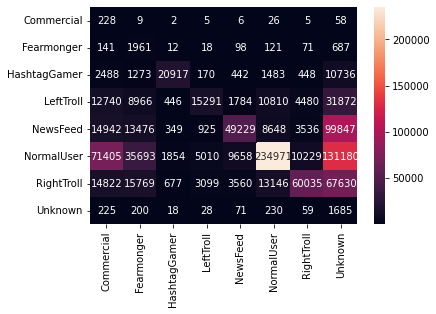

In [190]:
import seaborn as sns
cm = confusion_matrix(labs, predicted)
f = sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(list(lab2idx.keys())), yticklabels=sorted(list(lab2idx.keys())))

In [182]:
bin_labs = [l if l=='NormalUser' else 'TrollUser' for l in labs]
bin_preds = [l if l=='NormalUser' else 'TrollUser' for l in predicted]
print(classification_report(bin_labs, bin_preds, target_names=['NormalUser', 'TrollUser']))
#Normal: .87, .47, .61
#Troll: .64, .93, .76
#acc .7, prf: 0.75, 0.7, 0.68

              precision    recall  f1-score   support

  NormalUser       0.87      0.47      0.61    500000
   TrollUser       0.64      0.93      0.76    500000

    accuracy                           0.70   1000000
   macro avg       0.75      0.70      0.68   1000000
weighted avg       0.75      0.70      0.68   1000000



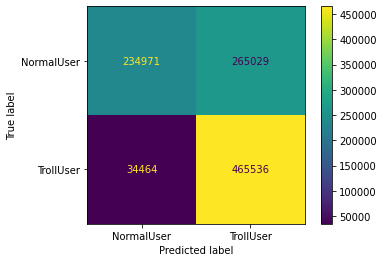

In [188]:
cm = confusion_matrix(bin_labs, bin_preds) #, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['NormalUser', 'TrollUser'])
cmd.plot()

In [192]:
d2v_lemmas_128_vecs_100000 = np.load('d2v_lemmas_128_0.npy')
labs_100000 = labs[:100001]
d2v_lemmas_128_vecs_100000.shape

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.140113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.301727
[t-SNE] KL divergence after 2000 iterations: 2.430488


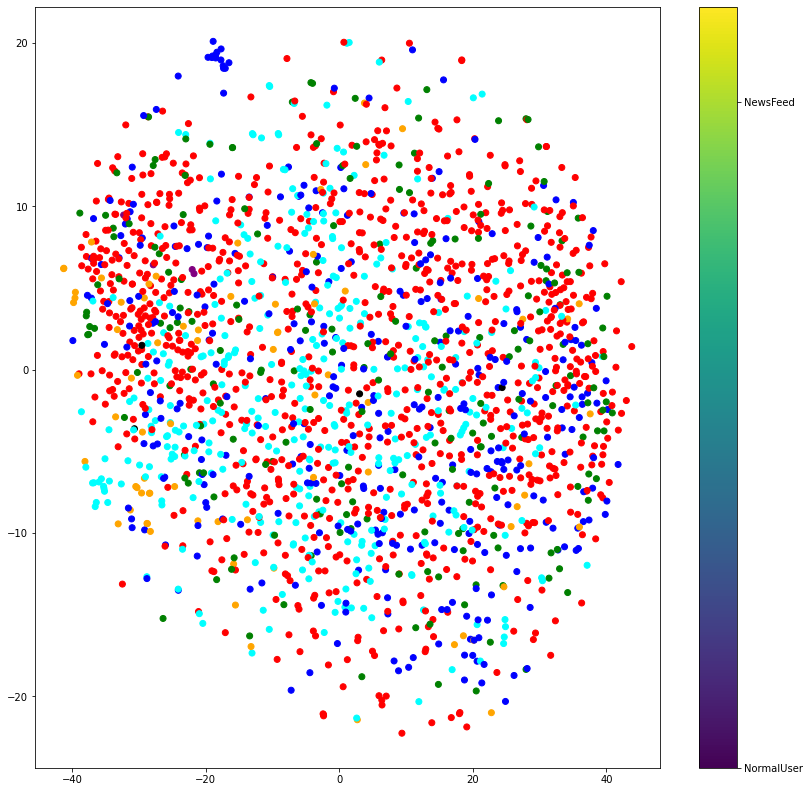

In [206]:
plot_tsne(d2v_lemmas_128_vecs_100000[:2000], [lab2idx[l] for l in labs_100000[:2000]], idx2lab)

In [ ]:
# scaled inverse frequency sentence embeddings

In [78]:
lemma_vocab_cts = Counter(' '.join(lemmas).split(' '))
len(lemma_vocab_cts)

273058

In [ ]:
def get_inverse_frequency_word_weights(vocab_cts, alpha=1e-3):
    corpus_size = 0
    wt = np.zeros(len(vocab_cts))
    words = []
    i=0
    for word, count in vocab_cts.items():
        words.append(word)
        corpus_size += count
        wt[i] = count
        i+=1
    wt /= corpus_size

    wt = (alpha / (alpha + wt))
    
    word_weights = {word:wt[i].item() for i,word in enumerate(words)}
    
    return word_weights

In [ ]:
#needed for inverse frequency word vector weighting
word_weights = get_inverse_frequency_word_weights(vocab_cts)

with open('lemma_wts.pkl', 'wb') as o:
    pickle.dump(word_weights, o)

In [ ]:
def scale_word_vecs_by_inverse_frequency(w2v_model, word_weights):
    '''Scale word vecs by inverse frequency'''
    word_vecs = {}
    
    for word, wt in word_weights.items():
        word_vecs[word] = w2v_model.wv[word] * wt
        
    return word_vecs

In [ ]:
# scale the word vecs by inverse frequency
sif_word_vecs = scale_word_vecs_by_inverse_frequency(w2v_model, word_weights)

In [ ]:
def get_all_sum_scaled_word_vecs(docs, sif_word_vecs):
    '''Sum the scaled word vecs and stack resulting doc vecs'''
    vecs = []
    for doc in docs:
        vec = get_sum_scaled_word_vecs(doc, sif_word_vecs)
        vecs.append(vec)
    vecs = np.vstack(vecs)
    
    return vecs


def get_sum_scaled_word_vecs(words, sif_word_vecs):
    '''Sum the scaled word vecs in a single song'''
    vecs = np.vstack([sif_word_vecs[word] for word in words])
    return np.sum(vecs, axis=0)/vecs.shape[0]

In [ ]:
# average the weighted word vecs to get a song vec for each song
sfe_lemmas_128_vecs = get_all_sum_scaled_word_vecs(lemmas, sif_word_vecs)
sfe_lemmas_128_vecs.shape

In [ ]:
def remove_first_singular_values(vecs, svd_path):
    '''Train SVD and remove projection of first singular vec from the vector set.
    This is done because of the assumption of a "default context" present in the sequence to be aggregated.'''
    if os.path.exists(svd_path):
        print('Loading trained SVD model')
        svd = joblib.load(svd_path)
    else:
        svd = TruncatedSVD(n_components=1, n_iter=10, random_state=42, algorithm="randomized")
        svd.fit(vecs)
        joblib.dump(svd, svd_path)

    sing_vecs = svd.components_

    #subtract u*u.T*v from sent vecs
    vecs -= vecs.dot(sing_vecs.T) * sing_vecs
    
    return vecs, svd

In [ ]:
# remove the first singular component from each song vec to decorrelate their "default context"
svd_path = 'sfe_lemmas_128_vecs.joblib'
sfe_lemmas_128_vecs, svd = remove_first_singular_values(sfe_lemmas_128_vecs, svd_path)